In [80]:
using Pkg
Pkg.add("POMDPs")
Pkg.add("POMDPModelTools")
Pkg.add("Distributions")
Pkg.add("POMDPPolicies")  # For random policy, you might need different packages for other policies like POMCP
Pkg.add("POMDPSimulators")
Pkg.add("POMDPModels")
Pkg.add("Printf")
Pkg.add("Plots")
Pkg.add("PointBasedValueIteration")
Pkg.add("SARSOP")
Pkg.add("POMCPOW")
Pkg.add("POMDPTools")
Pkg.add("Measurements")
Pkg.add("PlotMeasures")
Pkg.add("DiscreteValueIteration")
Pkg.add("MCTS")
using POMDPs
using POMDPModelTools
using Distributions
using POMDPPolicies  # For random policy, you might need different packages for other policies like POMCP
using POMDPSimulators
using POMDPModels
using Printf
using POMDPSimulators
using POMDPPolicies
using Plots
using PointBasedValueIteration
using SARSOP
using POMCPOW
using POMDPModels
using POMDPTools
using Measurements
using Plots.PlotMeasures
using DiscreteValueIteration
using MCTS

In [81]:
struct driveState
    h::Int
    r::Int
    z::Int
    phi::Int
end

In [82]:
#return probability of action = "stop"
function human_policy(h, r,  z)
    if h != 0 || r !=0 # maybe the not equal operation is not working here
        return 0.5
    end
    if z == 0
        return 0.9
    else
        return 0.1
    end
end


human_policy (generic function with 1 method)

In [83]:
# return updated z
function human_dynamics(h, r, z, phi)
    if phi == 0
        return z
    else
        if h == 1 && r == 1
            return 0
        else
            return z
        end
    end
end

human_dynamics (generic function with 1 method)

In [84]:
struct driveMDP <: MDP{driveState, Int} # POMDP{State, Action}
    discount_factor::Float64 # discount 
end

In [85]:
driveMDP() = driveMDP(0.95)
s = driveState[] # initialize an array of GridWorldStates
for phi = 0:1, z = 0:1, y = 0:1, x = 0:1
    push!(s, driveState(x,y,z,phi))
end
POMDPs.states(mdp::driveMDP) = s
mdp_2 = driveMDP() 

driveMDP(0.95)

In [86]:
function POMDPs.stateindex(mdp::driveMDP, state::driveState)  
    idx = 1 + state.h*(2^0) + state.r*(2^1) + state.z*(2^2)+ state.phi*(2^3) # check if idx is being correctly returned
    return idx 
end

In [87]:
POMDPs.actions(mdp::driveMDP) = [0, 1]

In [88]:
function POMDPs.actionindex(mdp::driveMDP, act::Int64)
    if act==0
        return 1
    elseif act==1
        return 2
    end
end

In [89]:
function POMDPs.reward(mdp::driveMDP, state::driveState, act::Int64)
    h = state.h
    r = state.r
    if h == 0 && r == 0
        rwd = 0
    elseif h == 1 && r == 0
        rwd = -3
    elseif h == 1 && r == 1
        rwd = -10
    elseif h == 0 && r == 1
        rwd = +5
    else
        rwd = 0
    end
    return rwd
end

In [90]:
function POMDPs.transition(mdp::driveMDP, state::driveState, act::Int64)
    h, r, z, phi = state.h, state.r, state.z, state.phi
    a = act
    p_stop = human_policy(h, r, z)
    z = human_dynamics(h,r,z,phi)

    # reset the game
    if h > 0 || r > 0
        return Deterministic(driveState(0,0,z,phi))
    elseif h == 0 && r == 0
        if a == 0
            return SparseCat([driveState(0,0,z,phi), driveState(1,0,z,phi)], [p_stop, 1-p_stop])
        elseif a == 1
            return SparseCat([driveState(0,1,z,phi), driveState(1,1,z,phi)], [p_stop, 1-p_stop])
        else
            return Deterministic(driveState(0,0,z,phi))
        end
    else
        return Deterministic(driveState(0,0,z,phi))
    end
end

In [91]:
function plot_data(h, r, rwd, plot_title)
    # Ensure h, r, and rwd are of the same length
    min_length = min(length(h), length(r), length(rwd))
    h, r, rwd = h[1:min_length], r[1:min_length], rwd[1:min_length]

    # Filter data
    indices_to_keep = [1]  # Always keep the first instance
    for i in 2:length(h)
        if !(h[i] == 0 && r[i] == 0)
            push!(indices_to_keep, i)
        end
    end
    h_filtered, r_filtered, rwd_filtered = h[indices_to_keep], r[indices_to_keep], rwd[indices_to_keep]

    # Create the first subplot with scatter points
    p1 = plot(h_filtered, label=nothing, xlabel="Steps", ylabel="Position", 
              left_margin=10px, bottom_margin=30px)
    scatter!(p1, h_filtered, label="Human States")
    plot!(p1, r_filtered, label=nothing)
    scatter!(p1, r_filtered, label="Robot States")
    plot!(p1, legend=:outertopright)

    # Calculate cumulative reward and create the second subplot
    cum_rwd = cumsum(rwd_filtered)
    p2 = plot(cum_rwd, label="Cumulative Reward", xlabel="Steps", ylabel="Cumulative Reward", 
              left_margin=10px, bottom_margin=30px)
    plot!(p2)

    # Combine p1 and p2 into one figure with the main title
    combined_plot = plot(p1, p2, layout=(1, 2), size=(800, 400))

    # Save the plot as an SVG file
    savefig(combined_plot, "combined_plot.svg")

    # Display the plot
    display(combined_plot)
end


plot_data (generic function with 1 method)

In [93]:
POMDPs.initialstate(mdp::driveMDP) = Deterministic(driveState(0, 0, 1, 1))
POMDPs.discount(mdp::driveMDP) = mdp.discount_factor
mdp_3 = driveMDP()

driveMDP(0.95)

In [94]:
# first let's load the value iteration module

human_pos = []
robot_pos = []
reward_pos = []

# initialize the solver
# max_iterations: maximum number of iterations value iteration runs for (default is 100)
# belres: the value of Bellman residual used in the solver (defualt is 1e-3)
# solver = ValueIterationSolver(max_iterations=100, belres=1e-3; verbose=true)

n_iter = 100000
depth = 10
ec = 10.0

solver = MCTSSolver(n_iterations=n_iter,
    depth=depth,
    exploration_constant=ec,
    enable_tree_vis=true
)

# solve for an optimal policy
mcts_policy = solve(solver, mdp_3); 

for (s,a,r) in stepthrough(mdp_3, vtr_policy, "s,a,r", max_steps=30)
    push!(human_pos, s.h)
    push!(robot_pos, s.r)
    push!(reward_pos, r)
end

s = driveState(0, 0, 1, 1)
a = 0
r = 0

s = driveState(1, 0, 1, 1)
a = 0
r = -3

s = driveState(0, 0, 1, 1)
a = 0
r = 0

s = driveState(0, 0, 1, 1)
a = 0
r = 0

s = driveState(1, 0, 1, 1)
a = 0
r = -3

s = driveState(0, 0, 1, 1)
a = 0
r = 0

s = driveState(1, 0, 1, 1)
a = 0
r = -3

s = driveState(0, 0, 1, 1)
a = 0
r = 0

s = driveState(0, 0, 1, 1)
a = 0
r = 0

s = driveState(1, 0, 1, 1)
a = 0
r = -3

s = driveState(0, 0, 1, 1)
a = 0
r = 0

s = driveState(1, 0, 1, 1)
a = 0
r = -3

s = driveState(0, 0, 1, 1)
a = 0
r = 0

s = driveState(1, 0, 1, 1)
a = 0
r = -3

s = driveState(0, 0, 1, 1)
a = 0
r = 0

s = driveState(1, 0, 1, 1)
a = 0
r = -3

s = driveState(0, 0, 1, 1)
a = 0
r = 0

s = driveState(1, 0, 1, 1)
a = 0
r = -3

s = driveState(0, 0, 1, 1)
a = 0
r = 0

s = driveState(1, 0, 1, 1)
a = 0
r = -3

s = driveState(0, 0, 1, 1)
a = 0
r = 0

s = driveState(1, 0, 1, 1)
a = 0
r = -3

s = driveState(0, 0, 1, 1)
a = 0
r = 0

s = driveState(1, 0, 1, 1)
a = 0
r = -3

s = driveState(0, 0, 1, 1)
a 

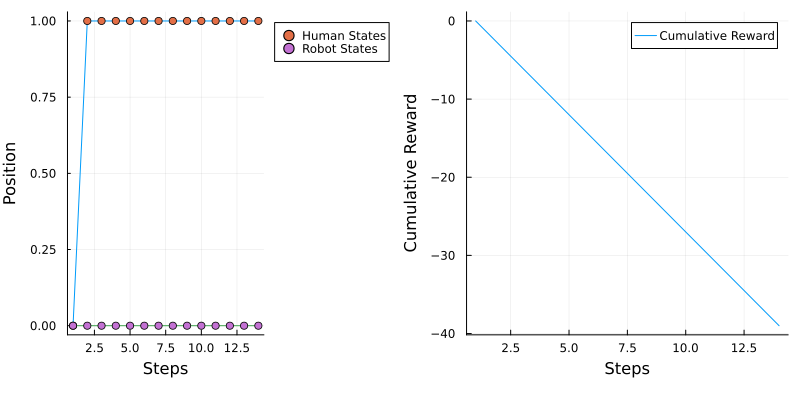

In [95]:
plot_title = "value_itr_solver"
plot_data(human_pos, robot_pos, reward_pos, plot_title)